# Cuaderno 1: Explicación del proceso estocástico con transformada de Karhunen-Loéve
### Caso 1D: Falla con variaciones de slip a lo largo del dip (along down-dip)
Ejemplo de referencia: R. J LeVeque et al. 2016

#### Teorema K-L

### $X_t=\sum_{k=1}^\infty Z_ke_k(t)$

### Para la generación estocástica de Slips:
# $Slip=\mu+\sum_{k=1}^Nz_k\sqrt{\lambda_k}v_k$

Una analogía puede ser la serie de fourier

$F(t) = a_0 + \sum_{n=1}^{\infty} \left( a_n \cos\left(\frac{2\pi n t}{T}\right) + b_n \sin\left(\frac{2\pi n t}{T}\right) \right)$

Importamos los paquetes necesarios, es decir, geostochpy

In [1]:
import sys
sys.path.append('../')
import geostochpy
import numpy as np
import matplotlib.pyplot as plt

Primero, crearemos un ejercicio en donde nos importa la variación del Slip a lo largo del dip.
Trabajando en un espacio de coordenadas X-Y, La variación sería a lo largo de X.
Estableceremos, para este caso, 200 Subfallas (Particularmente alto), para un espacio (Ancho) de 100 km.
lo que cada subfalla tendría 

$N*dx=Ancho$ , $dx=\frac{Ancho}{N}=\frac{100}{200}=0.5km$ 

Además, se asumirá que la falla presenta un dip de $13\degree$, y una magnitud de momento de 9.0, una rigidez constante (por simplicidad) de 3.55e10 N*m

Las profundidades de cada subfalla también deben ser definidas, para este ejemplo será lineal desde 5000 m hasta 22500 m


In [3]:
x=np.linspace(0,100,200) # Posición de cada subfalla en eje X
y=np.ones((200,1)) # Posición de cada subfalla en eje Y
# propiedades de la falla
dip=13*np.ones((200,1))
rigidez=3.55e10*np.ones((200,1))
ancho=100
profundidades= np.linspace(8000,55000,200)


Definimos algunas funciones ...

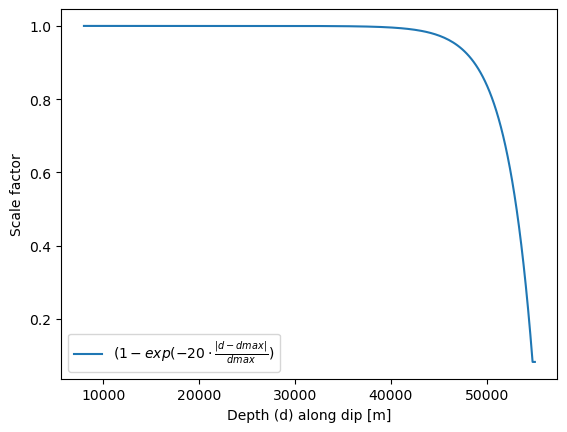

In [15]:
taper=geostochpy.taper_LeVeque(profundidades,55000)
plt.plot(profundidades,taper,label=r'$(1 - exp( -20\cdot\frac{| d - dmax |}{dmax} )$')
plt.xlabel('Depth (d) along dip [m]')
plt.ylabel('Scale factor')
plt.legend()

Definimos la matriz de covarianza $\hat{C}_{ij} =\sigma_i \sigma_j C_{ij}$ en donde $\sigma_i=\alpha \mu_i$ para algun escalar $\alpha \in \mathbb{R}$, y C es la matriz de correlación. Ya que $\alpha$ escala la desviacion estandar relativa al promedio, con 0.75 se asegura que el slip se mantenga positivo en donde sea. Se define la matriz de correlación como 

$C_{ij}=corr(|x_i-x_j|)$, en terminos de alguna funcion de autocorrelacion corr(r), en donde se eligió:

$ corr(r)=exp(-r/r_o)$

El autor propone un alpha de 0.75, y el slip promedio es ponderado por el taper, por ejemplo, daremos una media de 10 m.

In [332]:
def corr_1d_Leveque(x,r_0):
    matrix_corr=np.ones((x.size,x.size))
    for i in range(x.size):
        for j in range(x.size):
            r=np.abs(x[i]-x[j])
            matrix_corr[i,j]=np.exp(-r/r_0)
    return matrix_corr

def cov_1d_Leveque(corr_matrix,alpha,mean_slip):
    matrix_cov=np.ones((corr_matrix.shape[0],corr_matrix.shape[1]))
    for i in range(corr_matrix.shape[0]):
        for j in range(corr_matrix.shape[1]):
            matrix_cov[i,j]=alpha**2*mean_slip[i]*mean_slip[j]*corr_matrix[i,j]
    return matrix_cov

(-1.1, 1.1)

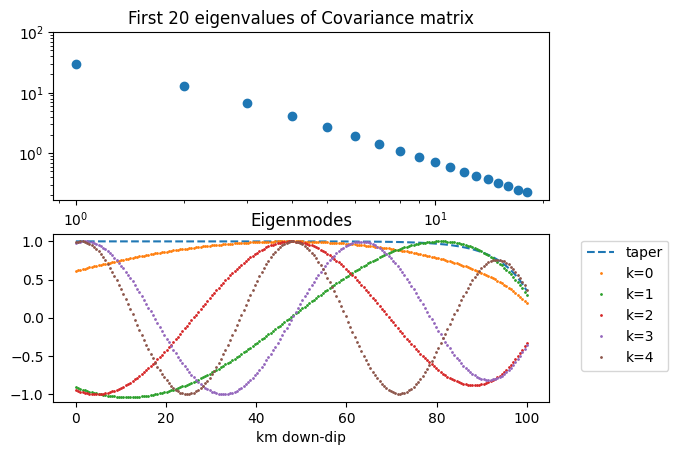

In [357]:
r_0=0.4*ancho # en km
Matriz_correlacion=corr_1d_Leveque(x,r_0)

#
mean_slip=1*np.ones((x.size,1)).T
mean_slip=(mean_slip*taper).flatten()
#
matriz_covarianza=cov_1d_Leveque(Matriz_correlacion,0.75,mean_slip)
eigen_valores,eigen_vectores=np.linalg.eig(matriz_covarianza)

# obtenemos los primero 20 valores
eigen_valores20,eigen_vectores20=eigen_valores[0:19],eigen_vectores[:,0:19]
fig,axes=plt.subplots(2,1)
axes[0].loglog(eigen_valores20,'o')
axes[0].set_xlabel('Eigenvalores')
axes[0].set_title('First 20 eigenvalues of Covariance matrix')

#
axes[1].plot(x,taper,'--',label='taper')
for i in range(5):
    axes[1].plot(x,eigen_vectores20[:,i]/np.max(eigen_vectores20[:,i]),label=f'k={i}',marker='.',linewidth=0,markersize=2)
    

axes[1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
axes[1].set_xlabel('km down-dip')
axes[1].set_title('Eigenmodes')
axes[1].set_ylim((-1.1,1.1))


Se puede ver La alta similitud del eigenvector cuando k=0 con el taper